Shape: (4424, 35)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   evening attendance                              4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Nacionality                                     4424 non-null   int64  
 7   Mother's qualification                          4424 non-null   int64  
 8   Father's qualification                          4424 non-null   int64  
 9   Mother's occupation    

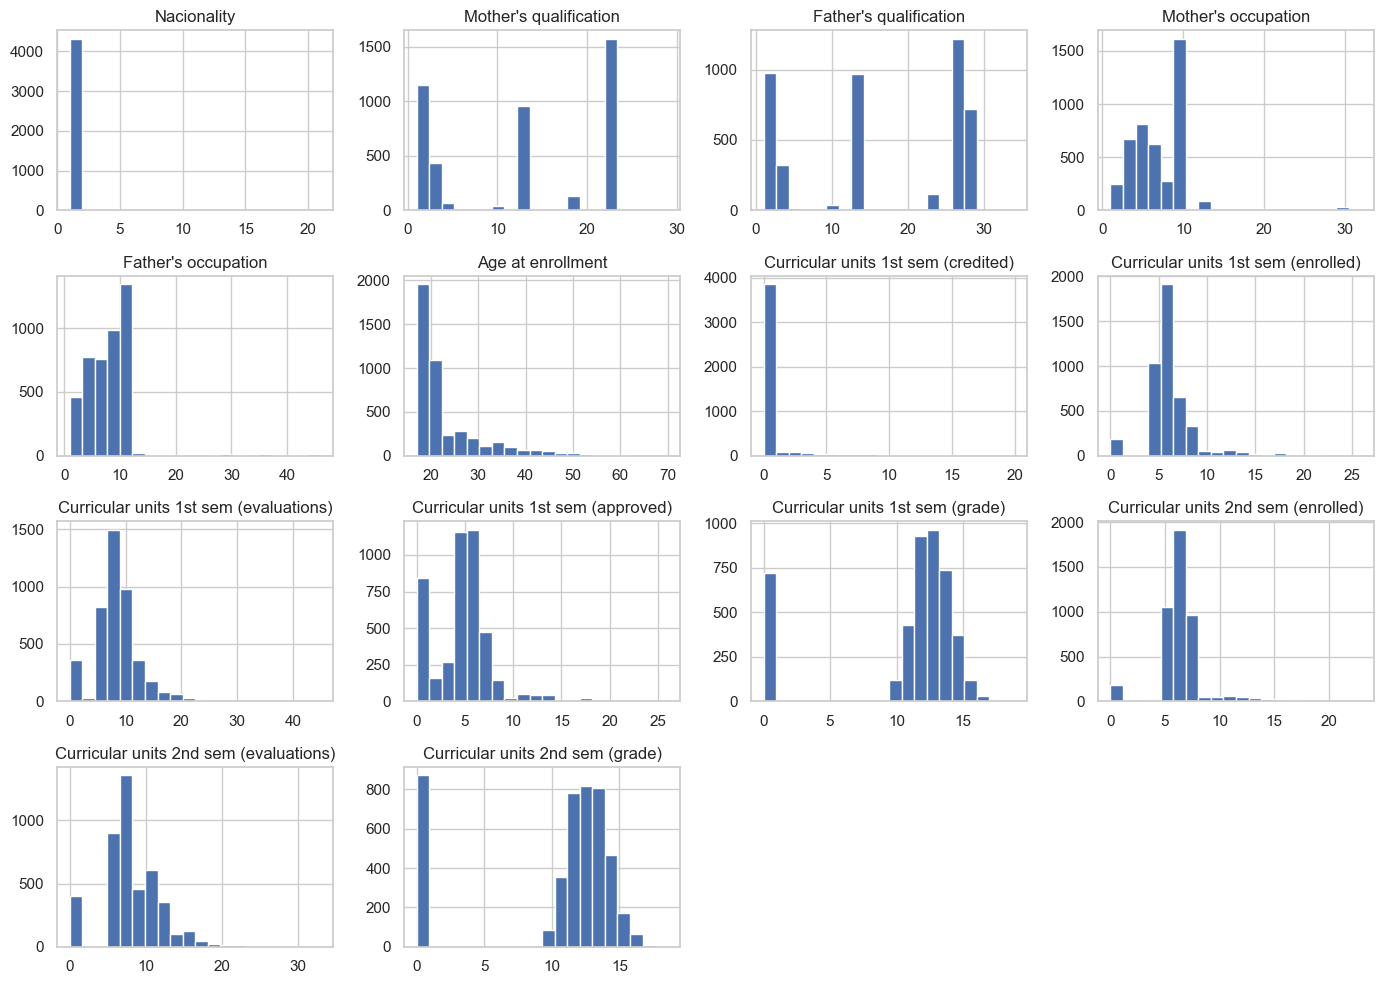

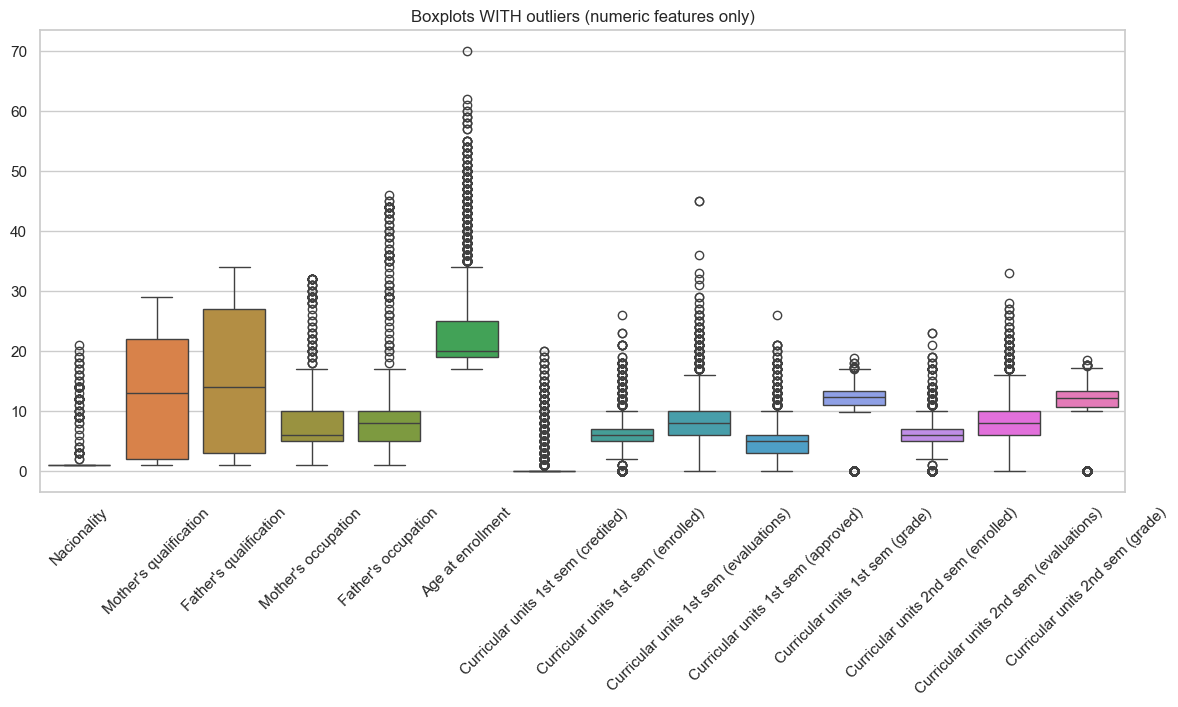

Shape without outliers: (2028, 35)


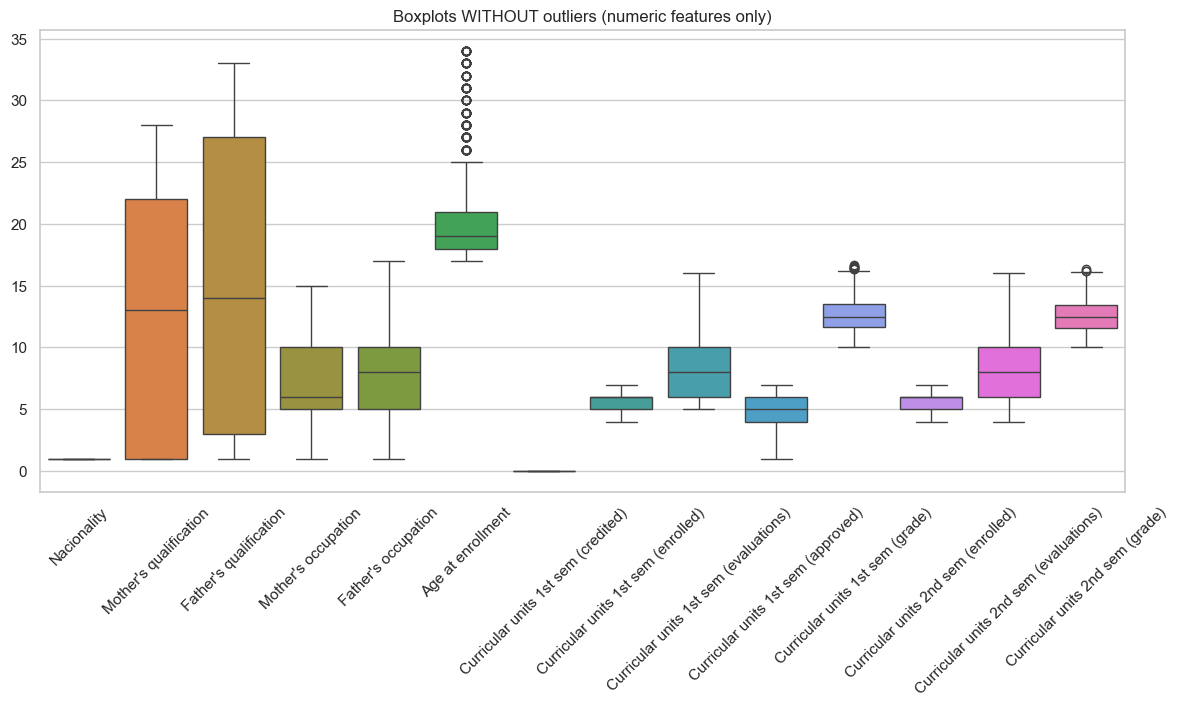

Generating side-by-side boxplots...


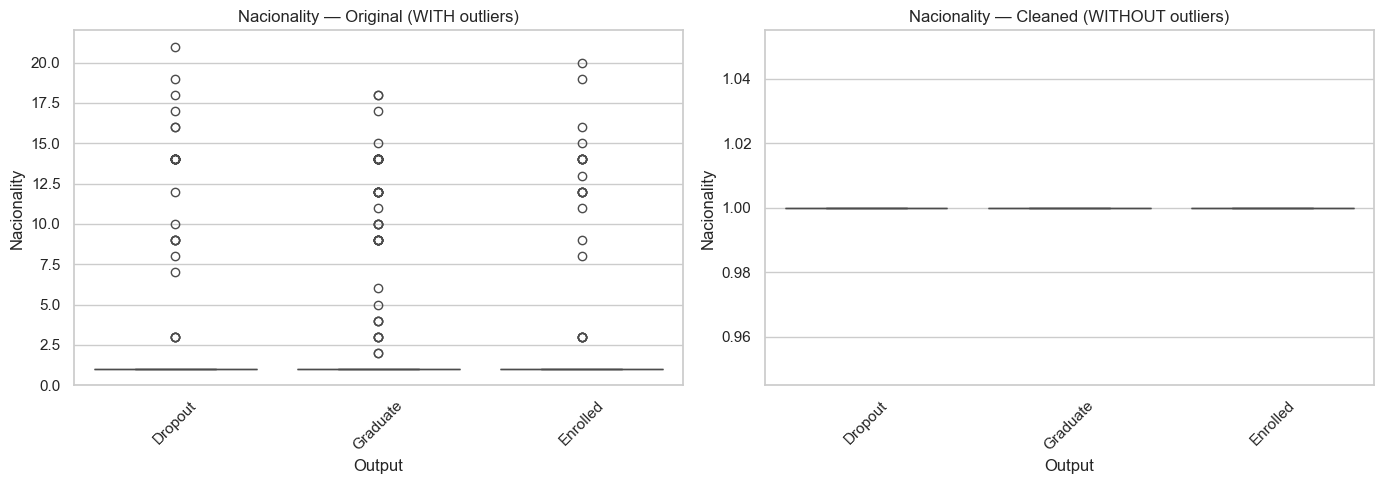

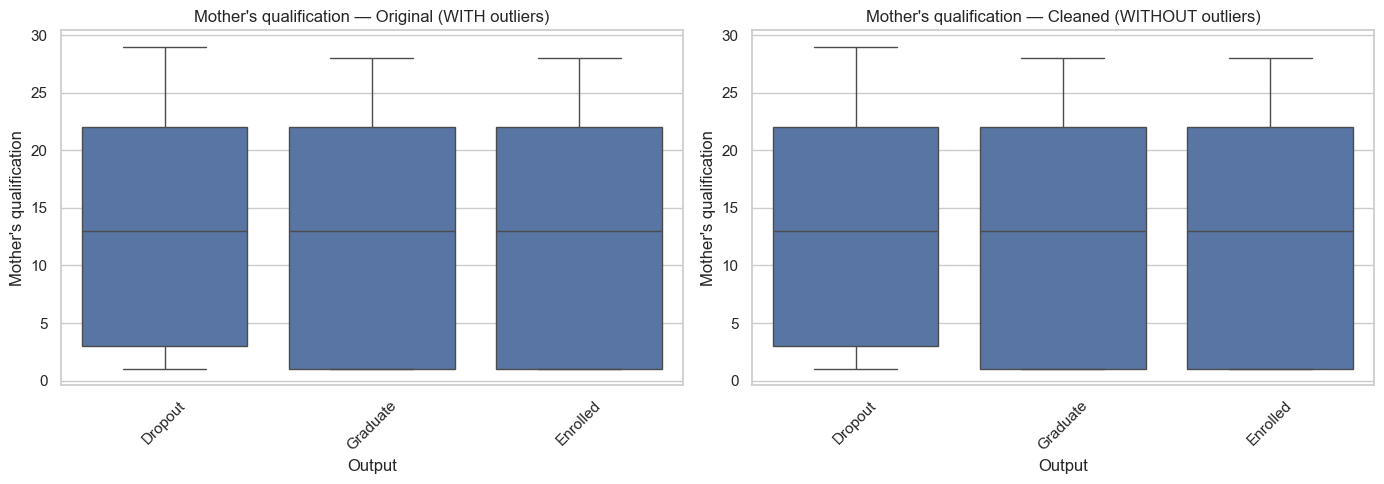

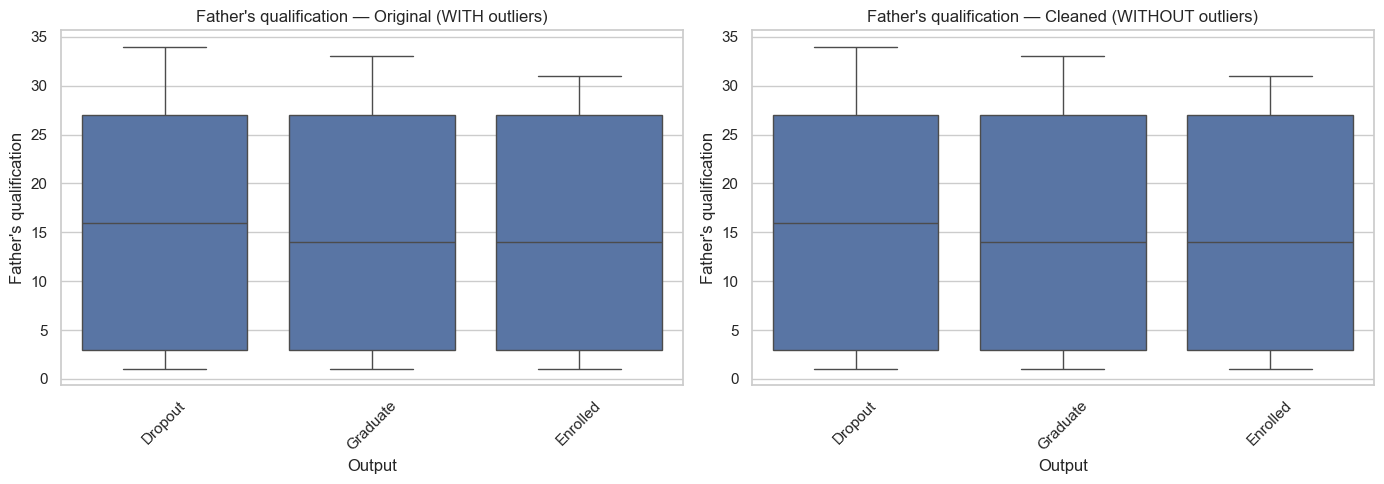

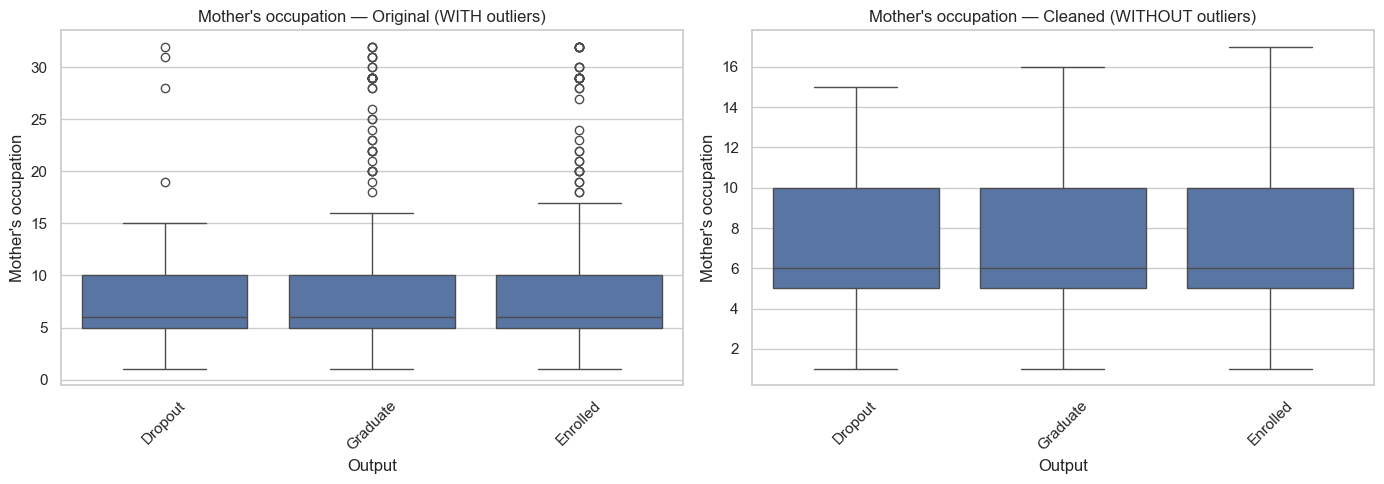

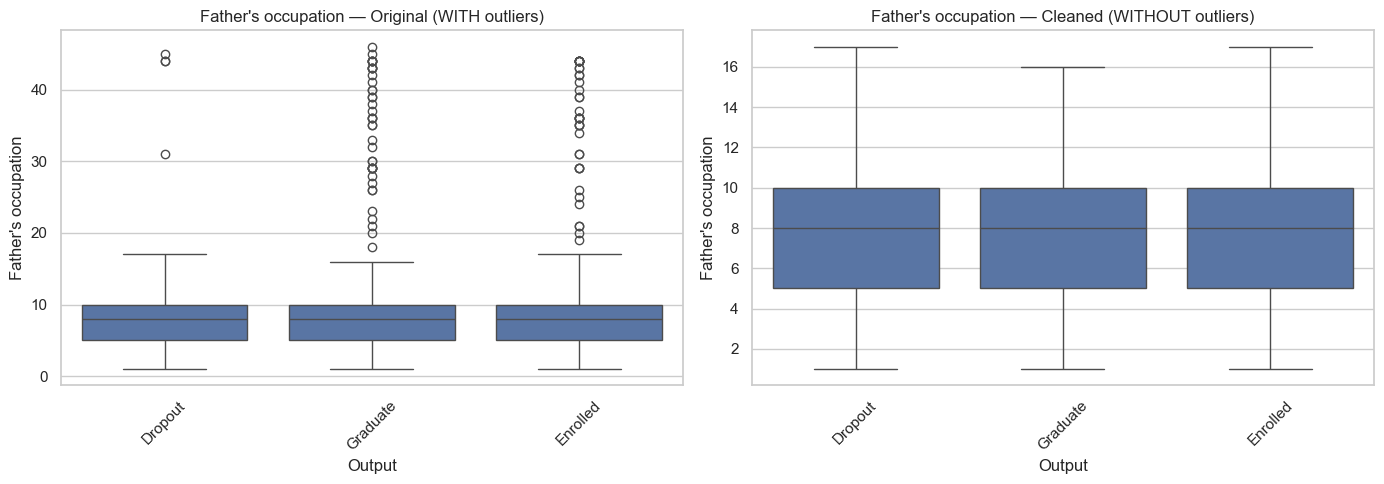

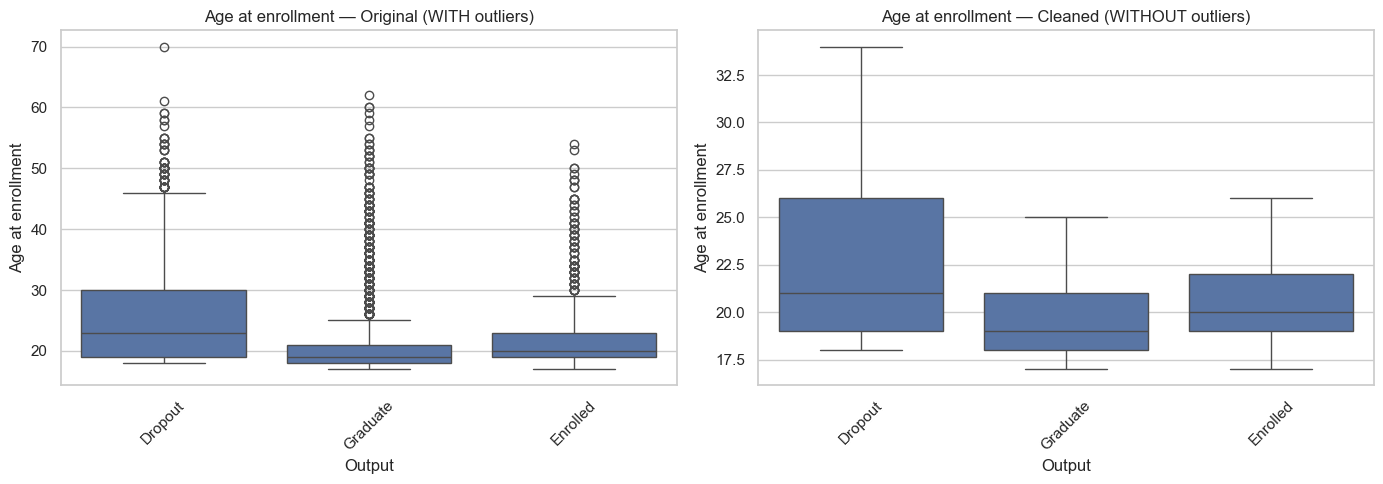

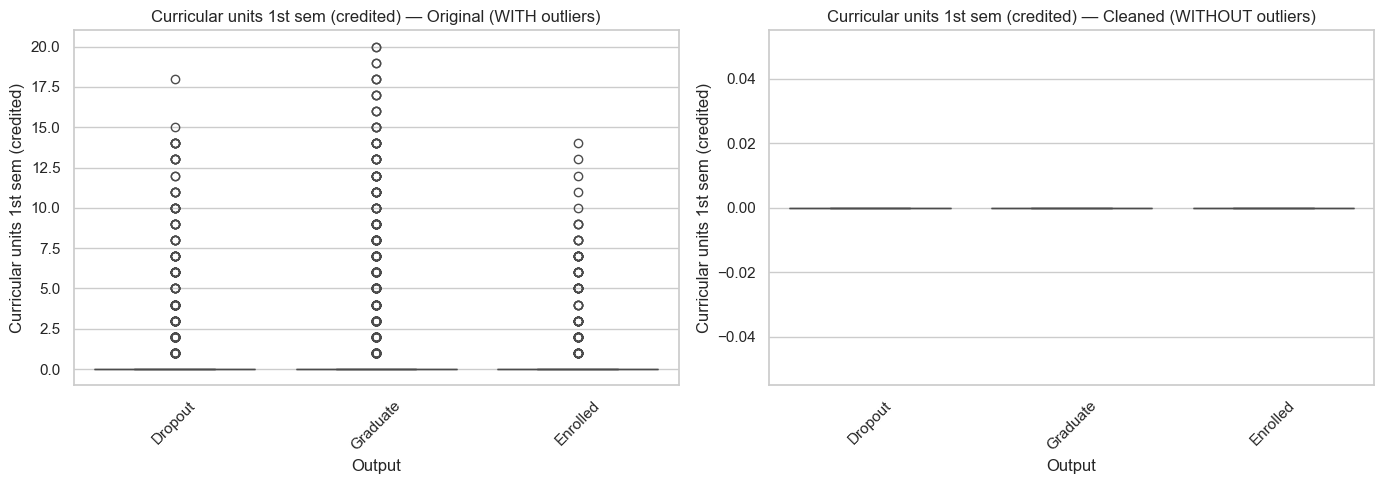

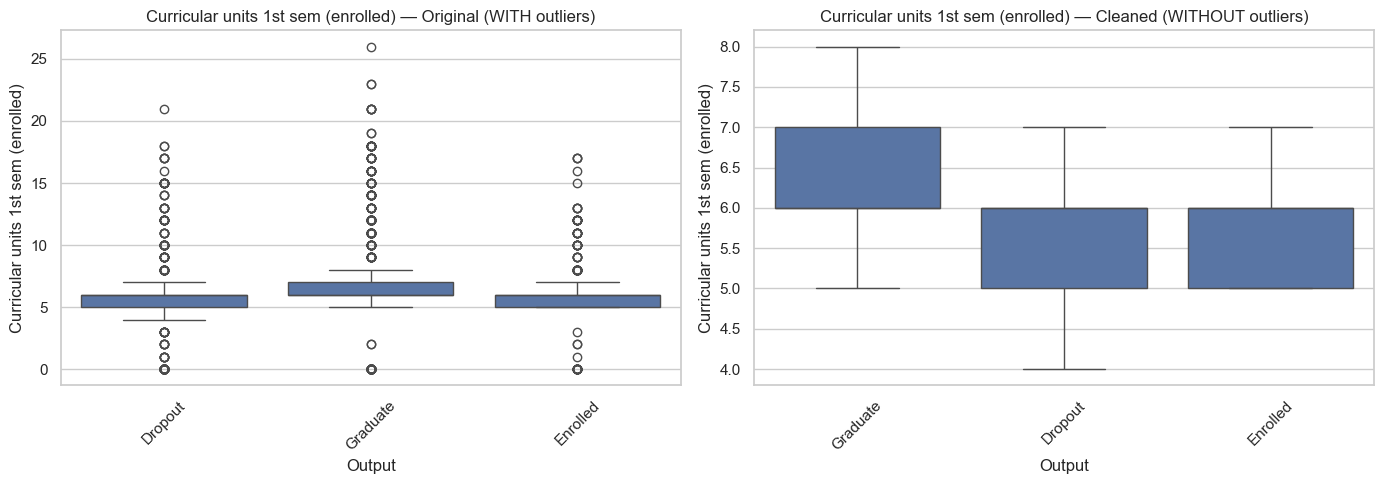

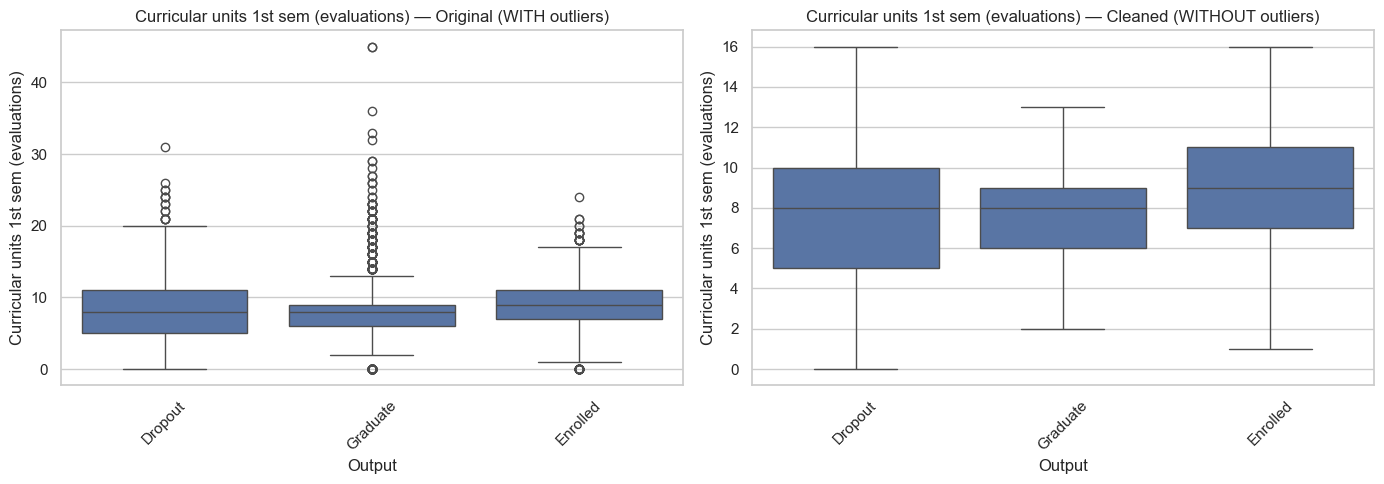

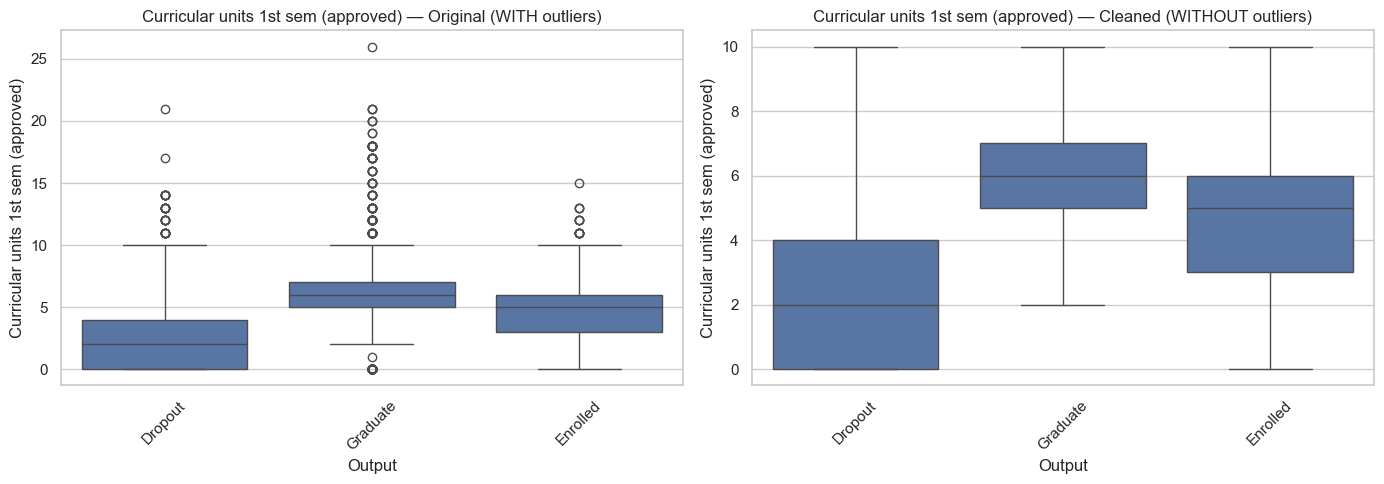

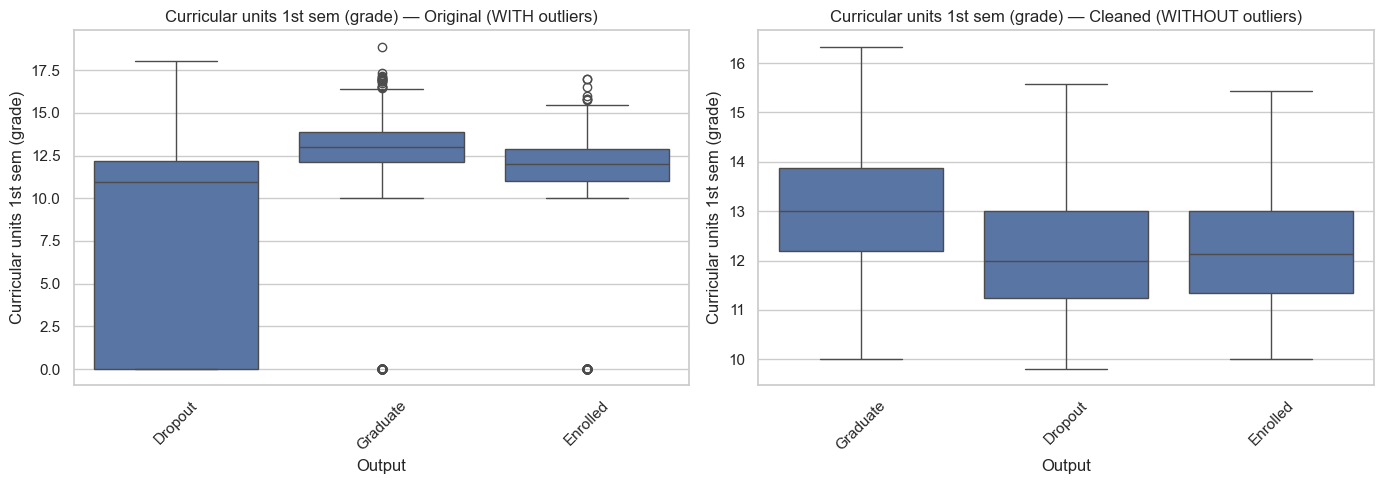

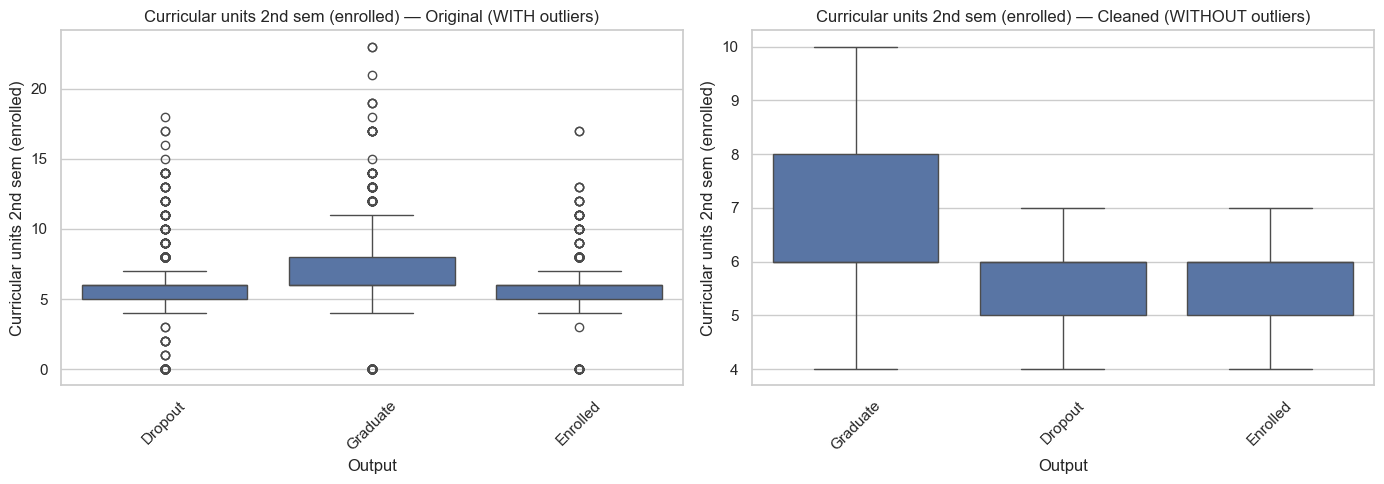

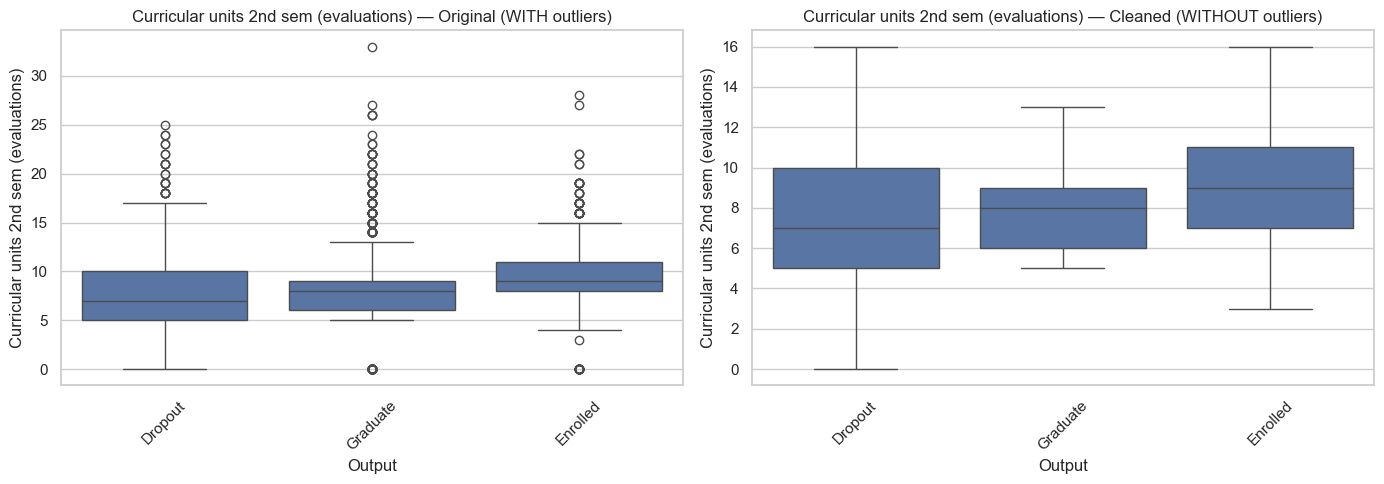

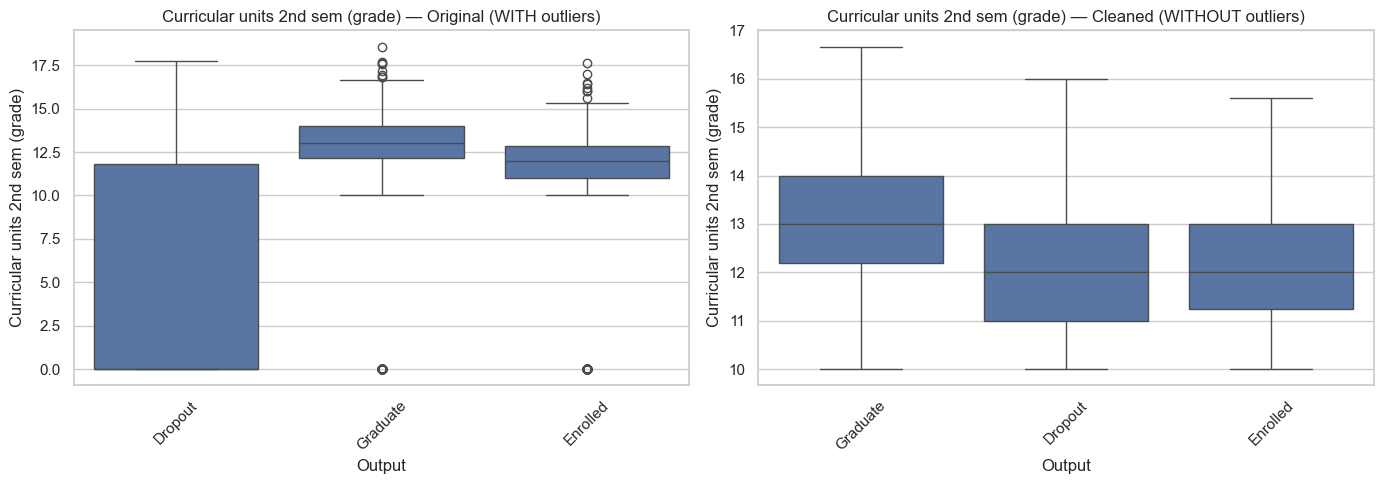

Train shape: (3539, 34)
Test shape: (885, 34)
Numeric columns: ['Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Age at enrollment', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (grade)']
Categorical columns: ['Application mode', 'Application order', 'Course', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (without evaluations)', 'Debtor', 'Displaced', 'Educational special needs', 'GDP', 'Gender', 'Inflation rate', 'International', 'Marital status', 'Previous qualification', 'Scholarship holder', 'Tuition fees up to date', 'Unemployment rate', 'evening attendance']

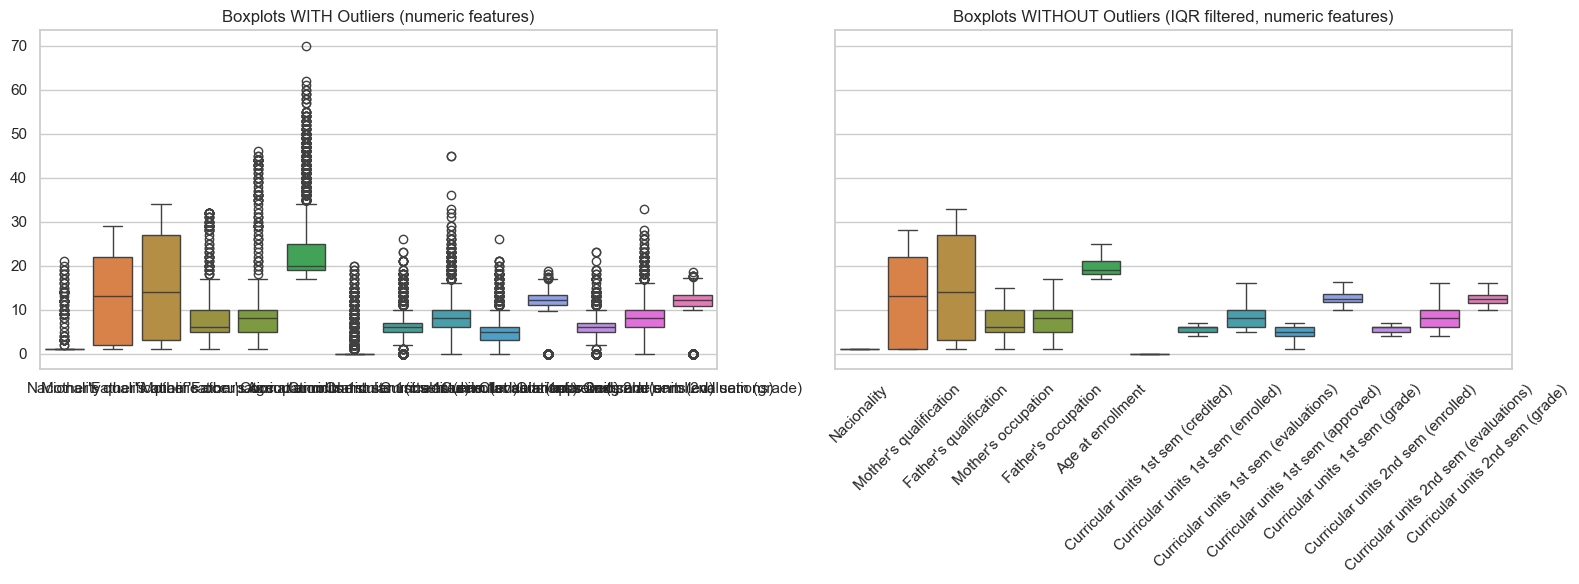

In [1]:
# %%
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    cohen_kappa_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

CSV_PATH = "student_data.csv"
TARGET_COL = "Output"

df = pd.read_csv(CSV_PATH, sep=";")
print("Shape:", df.shape)
df.head()

# %%
df.info()
df.describe(include='all').T

# --- NEW: helper to separate numeric vs categorical correctly ----
def infer_columns(df: pd.DataFrame, target: str):
    """
    Treat low-cardinality integer columns as categorical.
    This avoids interpreting coded categories (0/1/2, etc.) as numeric.
    """
    X = df.drop(columns=[target])

    # start with obvious categoricals
    cat_cols = list(X.select_dtypes(include=["object", "category"]).columns)

    # integers / floats with few unique values are also categorical
    for c in X.select_dtypes(include=["int64", "int32", "int16", "int8", "float64", "float32"]).columns:
        if X[c].nunique() <= 20:   # threshold can be adjusted
            cat_cols.append(c)

    cat_cols = sorted(set(cat_cols))
    num_cols = [c for c in X.columns if c not in cat_cols]
    return num_cols, cat_cols

# use it here:
numeric_cols, categorical_cols = infer_columns(df, TARGET_COL)
print("Numeric columns (treated as continuous):", numeric_cols)
print("Categorical columns:", categorical_cols)

# %%
# Histograms only for TRUE numeric columns
df[numeric_cols].hist(bins=20, figsize=(14, 10))
plt.tight_layout()
plt.show()

# %%
# Boxplots only for TRUE numeric columns
plt.figure(figsize=(14, 6))
sns.boxplot(data=df[numeric_cols])
plt.title("Boxplots WITH outliers (numeric features only)")
plt.xticks(rotation=45)
plt.show()

# %%
# Outlier removal only on numeric columns
df_no_outliers = df.copy()
for col in numeric_cols:
    Q1 = df_no_outliers[col].quantile(0.25)
    Q3 = df_no_outliers[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower) & (df_no_outliers[col] <= upper)]

print("Shape without outliers:", df_no_outliers.shape)

plt.figure(figsize=(14, 6))
sns.boxplot(data=df_no_outliers[numeric_cols])
plt.title("Boxplots WITHOUT outliers (numeric features only)")
plt.xticks(rotation=45)
plt.show()

# %%
TARGET = TARGET_COL

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

print("Generating side-by-side boxplots...")

for col in numeric_cols:   # again: ONLY numeric
    df_clean = remove_outliers_iqr(df, col)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    sns.boxplot(data=df, x=TARGET, y=col, ax=axes[0], showfliers=True)
    axes[0].set_title(f"{col} — Original (WITH outliers)")
    axes[0].tick_params(axis='x', rotation=45)

    sns.boxplot(data=df_clean, x=TARGET, y=col, ax=axes[1], showfliers=False)
    axes[1].set_title(f"{col} — Cleaned (WITHOUT outliers)")
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# --- Train/test split ----------------------------------------
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# We can re-use the same numeric/categorical separation (columns didn't change)
# or recompute using the helper (optional):
numeric_cols, categorical_cols = infer_columns(df, TARGET_COL)
print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# --- Preprocessing + pipelines --------------------------------
def build_preprocessor(scaler):
    """
    scaler: None, StandardScaler(), or MinMaxScaler()
    Applies scaler to numeric cols and OneHotEncoder to categorical cols.
    """
    transformers = []
    if numeric_cols:
        if scaler is None:
            transformers.append(("num", "passthrough", numeric_cols))
        else:
            transformers.append(("num", scaler, numeric_cols))
    if categorical_cols:
        transformers.append(("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols))

    preprocessor = ColumnTransformer(transformers=transformers)
    return preprocessor


def build_pipeline(scaler, model):
    preprocessor = build_preprocessor(scaler)
    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", model)
    ])
    return pipe

# --- Evaluation function (unchanged, just uses new pipelines) ----
def evaluate_pipeline(name, pipeline, X_train, y_train, X_test, y_test, positive_label=None):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    if cm.shape == (2, 2):
        TN, FP, FN, TP = cm.ravel()
        specificity = TN / (TN + FP) if (TN + FP) > 0 else np.nan
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else np.nan
    else:
        specificity = np.nan
        sensitivity = recall_score(y_test, y_pred, average="macro")

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="binary" if cm.shape == (2, 2) else "macro")
    recall = recall_score(y_test, y_pred, average="binary" if cm.shape == (2, 2) else "macro")
    f1 = f1_score(y_test, y_pred, average="binary" if cm.shape == (2, 2) else "macro")
    kappa = cohen_kappa_score(y_test, y_pred)

    cv_scores_5 = cross_val_score(pipeline, X_train, y_train, cv=5)
    cv_scores_10 = cross_val_score(pipeline, X_train, y_train, cv=10)

    result = {
        "setup": name,
        "accuracy": accuracy,
        "precision": precision,
        "recall (sensitivity)": recall,
        "specificity": specificity,
        "f1": f1,
        "kappa": kappa,
        "cv_mean_5": cv_scores_5.mean(),
        "cv_std_5": cv_scores_5.std(),
        "cv_mean_10": cv_scores_10.mean(),
        "cv_std_10": cv_scores_10.std()
    }
    return result

# --- Compare scaling setups ------------------------------------
log_reg = LogisticRegression(max_iter=5000, solver='lbfgs')

scaling_setups = [
    ("No scaling + LogisticRegression", None, log_reg),
    ("Z-score (StandardScaler) + LogisticRegression", StandardScaler(), log_reg),
    ("Unitization (MinMaxScaler) + LogisticRegression", MinMaxScaler(), log_reg),
]

results = []
for name, scaler, model in scaling_setups:
    pipe = build_pipeline(scaler, model)
    print(f"Evaluating: {name}")
    res = evaluate_pipeline(name, pipe, X_train, y_train, X_test, y_test)
    results.append(res)

results_df = pd.DataFrame(results)
results_df

# --- Outlier comparison plots again (numeric only) -------------
df_no_outliers = df.copy()
for col in numeric_cols:
    Q1 = df_no_outliers[col].quantile(0.25)
    Q3 = df_no_outliers[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    df_no_outliers = df_no_outliers[
        (df_no_outliers[col] >= lower) & (df_no_outliers[col] <= upper)
    ]

print("Original shape:", df.shape)
print("Without outliers:", df_no_outliers.shape)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

sns.boxplot(data=df[numeric_cols], ax=axes[0])
axes[0].set_title("Boxplots WITH Outliers (numeric features)")

sns.boxplot(data=df_no_outliers[numeric_cols], showfliers=False, ax=axes[1])
axes[1].set_title("Boxplots WITHOUT Outliers (IQR filtered, numeric features)")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
